# Programming Exercise 1 (Optional): Linear regression with multiple variables

Welcome to this second part of programming exercise 1! This exercise will take you through every step of how to implement linear regression with multiple variables from scratch using common scientific packages on provided sample data. 

**Instruction:**
- To run code, click on a corresponding cell and press `Shift+Enter` keys simultaneously or Click `Cell -> Run` Cells.

**Objective:**
- To implement Linear regression to predict a real-valued output based on an input value

**You will learn how to:**
- implement Linear regression with multiple variable
    - objective/cost function
    - gradient descent algorithm
    - Hypothesis testing
    - visualizing the objective function
- implement linear regression using Normal equation

## 1 - Packages ##

First lets run the cell below to import all the packages that you will need for this exercise.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python
- [matplotlib](http://matplotlib.org) is a common library to plot graphs in python.
- [os](https://docs.python.org/3/library/os.html#) is a Python module that provides a portable way of using operating system dependent functionality.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common python libraries
import numpy as np
import pandas as pd
import os

# To plot cool figures
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## 2 - Overview of the problem

Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.
The file `./data/ex1data2.txt` contains a training set of housing prices in Portland, Oregon. The frst column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price of the house.

Therefore, In this part of the exercise, we will implement linear regression with multiple variables to predict the prices of houses. 

## 3 - Loading training data

In [2]:
#IMPORTING DATA FILES
path = os.getcwd() + '\data\ex1data2.txt' #PATH TO THE DATASET
df = pd.read_csv(path, header=None, names=['Sq-ft Size', 'Bedrooms', 'Price'])
data=df.values
X = data[:,:2]
Y = data[:,2].reshape(-1,1)

In [3]:
# RESULTS CHECK
print('\nThe First 5 Normalized Features are:\n', X[:5,:])


The First 5 Normalized Features are:
 [[2104    3]
 [1600    3]
 [2400    3]
 [1416    2]
 [3000    4]]


We are able to tell from the out above that the dataset has two columns; `Sq-ft Size` and `Bedrooms`.

## Initial parameter settings##

In [4]:
# THETA INITIALIZATION & HYPERPARAMETER SETTINGS
theta = np.zeros((3, 1)); # Initialize Theta 
alpha = 0.1; # Choose some alpha value
num_iters = 50; # Number of Iterations

## 4 - Feature normalization

When you look at the values in the dataset, you will note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly.

In order to normalize the features `X`:
    - compute and subtract the mean value of each feature from the dataset.
    - After subtracting the mean, additionally scale (divide) the feature values by their respective "standard deviations".(Alternatively, you can take the range of values (max-min)

**Note:**
The standard deviation is a way of measuring how much variation there is in the range of values of a particular feature (most data points will lie within $\pm 2$ standard deviations of the mean);

By getting features in the same range, we can `speed up the gradient descent algorithm`. This is because $\theta$ will descend quickly on small ranges and slowly on large ranges, and so will oscillate inefficiently down to the optimum when the variables are very uneven.



Two techniques to help with this are `feature scaling` and `mean normalization`. 

`Feature scaling` involves dividing the input values by the range (i.e. the maximum value minus the minimum value) of the input variable, resulting in a new range of just 1. 

`Mean normalization` involves subtracting the average value for an input variable from the values for that input variable resulting in a new average value for the input variable of just zero. To implement both of these techniques, adjust your input values as shown in this formula:

${x_{i}} = \frac{x_{i}-\mu_{i}}{\ s_{i}} \tag{1}$
   

Where $\mu_{i}$ is the average of all the values for feature (i) and ${s_{i}}$ is the range of values (max - min), or ${s_{i}}$ is the standard deviation.

**Note** that dividing by the range, or dividing by the standard deviation, give different results.

So we shall define a function `featureNormalize()` that will take a multivariate matrix **X** and return a normalized X (`Xnorm`), a vector of mean values of each feature in X (`mu`) and and standard deviation values of each feature in X (`sigma`).

In [5]:
# FEATURE NORMALIZATION FUNCTION
def featureNormalize(x):
    # Computing the Mean and STD of x
    mu = np.mean(x, axis=0, keepdims=True);
    sigma = np.std(x, axis = 0, keepdims=True);
    # Normalize X 
    X_norm = (x - mu)/sigma
    return X_norm, mu, sigma

In [6]:
X_norm, mu, sigma = featureNormalize(X) #Feature Normalization
# RESULTS CHECK
print('\nThe First 5 Normalized Features are:\n' + str(X_norm[0:5,:])+'\n')
print('The computed MEAN:',mu)
print('The computed STD:',sigma)


The First 5 Normalized Features are:
[[ 0.13141542 -0.22609337]
 [-0.5096407  -0.22609337]
 [ 0.5079087  -0.22609337]
 [-0.74367706 -1.5543919 ]
 [ 1.27107075  1.10220517]]

The computed MEAN: [[2000.68085106    3.17021277]]
The computed STD: [[7.86202619e+02 7.52842809e-01]]


## 5 - Implementing Batch gradient descent algorithm for multivariate linear regression

Before getting into the details of implementations, let us review the theoretical concepts of multivariate linear regression. 

Previously, we implemented gradient descent on a univariate regression problem. The only difference now is that there is one more feature in the matrix X. The hypothesis function and the batch gradient descent update rule remain unchanged.

**5.1 - Hypothesis $h_\theta(x)$ representation:** 
The multivariable form of the hypothesis function accommodating these multiple features is as follows:

$$ h_\theta(x) = \theta^{T}x = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_3 + ..... + \theta_n x_n\tag{2}$$

In order to develop intuition about this function, we can think about $\theta_0$ as the basic price of a house, $\theta_1$ as the price per square meter, $\theta_2$ as the price per floor, etc. ${x_1}$ will be the number of square meters in the house, ${x_2}$ the number of floors, etc.

The function `hypothesisFunction()` implements the hypothesis function in `equation 2` above.

In [7]:
# PREDICTION FUNCTION
def hypothesisFunction(x, theta):
    return np.dot(x,theta)

**5.2 - Objective function:**
Like in the previous exercise, we are going to use the same objective function sometimes refered to as the `Squared error function` or `Mean squared error`. The `objective function` measures the accuracy of the given hypothesis function. Therefore, the aim of linear regression is to minimize the cost function ${J(\theta)}$:

$$ {J(\theta)} = \frac{1}{2m} \sum_{i=1}^m (\hat{y}^{(i)}-y^{(i)})^2 = \frac{1}{2m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})^2\tag{3}$$

**NOTE**: The mean is halved $\frac{1}{\ 2m}$ as a convenience for the computation of the gradient descent, as the derivation term of the squared function will cancel out the $\frac{1} {\ 2}$ term 

In the multivariate case, the cost function can be written in vectorised form as:
$$ {J(\theta)} = \frac{1}{2m} \sum_{i=1}^m (X\theta-\vec y)^T(X\theta-\vec y)\tag{4}$$


The function `computeCostMulti()` below implements the vectorized form of the objective function in equation 4 above!

In [8]:
# MULTIVARIATE COST FUNCTION
def computeCostMulti(x, y, theta):
    # Initialize some useful values
    m = x.shape[0]; # number of training examples
    h = hypothesisFunction(x, theta)
    J=(1/(2*m)) * (np.dot((h-y).T,(h-Y)))
    return J

** 5.3 - Gradient descent algorithm:** The next phase will be to define a `gradientDescentMulti()` function and run gradient descent for a number # iterations at the chosen learning rate $\alpha$. The function should also return the history of ${J{(\theta)}}$ values in a vector J.

The gradient descent equation itself is generally the same form; we just have to repeat it for our 'n' features: $\theta = \theta - \alpha \nabla {J{(\theta)}}$

The **gradient descent algorithm** will repeat until convergence {
$$\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)}).x_j^{(i)} \tag{5}$$
} for **j = 0...n**, where $x_0^{(i)}$ = **1**, **m** is the size of the training set. 

In this exercise we have two features. Our **gradient descent algorithm** will repeat until convergence {
$$\theta_0 = \theta_0 - \alpha \frac{1}{2m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)}).x_0^{(i)} $$
$$\theta_1 = \theta_1 - \alpha \frac{1}{2m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)}).x_1^{(i)} $$
$$\theta_2 = \theta_2 - \alpha \frac{1}{2m} \sum_{i=2}^m (h_\theta(x^{(i)})-y^{(i)}).x_2^{(i)} $$
} where $x_0^{(i)}$ = **1**, **m** is the size of the training set.

In order to implement the gradient descent we need a vectorized form of multivariate linear regression. The matrix notation (vectorized) of the Gradient Descent rule is: 
$$\frac{\partial J{(\theta)}}{\partial \theta_j} = \frac{1}{m}\vec x_j^ T(X\theta-\vec y)$$
$$\nabla {J{(\theta)}} = \frac{1}{m} X^T(X\theta-\vec y)$$

$$\theta = \theta - \frac{\alpha}{m} X^T(X\theta-\vec y)\tag{6}$$

In [9]:
# GRADIENT DESCENT ALGORITHM
def gradientDescentMulti(x, y, theta, alpha, num_iters,print_cost=False):
    # Initialize some useful values
    m = x.shape[0]; # number of training examples
    J_history = np.zeros((num_iters, 1));
    for iters in range(num_iters):
        h = hypothesisFunction(x, theta);
        diff = h - y;
        gradient = np.dot(x.T,diff) * (1/m);
        theta = theta - (alpha * gradient);
        # Save the cost J in every iteration    
        cost = computeCostMulti(x, y, theta);
        J_history[iters] = cost;
        if print_cost and iters % 10 == 0:
            print("After %i " % (iters) + "iterations: " +" Cost: %f" % (cost) +' ,' +' Theta' + str(theta[:,0]))
    return theta, J_history

Now we are ready to compute $\theta_0$, $\theta_1$ and $\theta_2$ by **running gradient descent** we have just implemented. `Run` the cell below ...!

In [10]:
X_new = np.insert(X_norm,0,1,axis=1) # Add intercept term to normalized X
print('\nRunning gradient descent algorithm ...\n')
theta, J_history = gradientDescentMulti(X_new, Y, theta, alpha, num_iters, print_cost=True)
print('\nAfter %d iterations:\n\t Minimum point: [%.9s, %.9s, %.9s]\n\t Cost: %d.\n'\
      %(num_iters, str(theta[:,0][0]),str(theta[:,0][1]), str(theta[:,0][2]),J_history[len(J_history)-1][0]));


Running gradient descent algorithm ...

After 0 iterations:  Cost: 53268259941.691589 , Theta[34041.26595745 10576.41334928  5470.88217559]
After 10 iterations:  Cost: 8398254002.783360 , Theta[233587.55995682  66122.66213488  20822.05752165]
After 20 iterations:  Cost: 2964019938.349604 , Theta[303165.05047626  85439.23797418  14509.32710359]
After 30 iterations:  Cost: 2218685269.075388 , Theta[327425.22133665  94802.72446494   7530.97657243]
After 40 iterations:  Cost: 2090516766.790118 , Theta[335884.21986881 100231.42876304   2539.74852551]

After 50 iterations:
	 Minimum point: [338658.24, 103322.82, -474.7424]
	 Cost: 2061269629.



**5.4 - Visualizing ${J{(\theta)}}$ vs the number of Iterations**

We have sucessfully trained and computed the $\theta_j$ values for our hypothesis. Let us now visualize how the cost ${J{(\theta)}}$ has been changing w.r.t. the number of iterations.

In [11]:
# DEFINING THE COST CONVERGENCE PLOT
def convergencePlot(j_hist):
    xvals = range(j_hist.size)
    plt.plot(xvals, j_hist, 'g-s');
    plt.grid(True)
    learning_rate = r"$\alpha = {}$".format(alpha)
    plt.title("Convergence of BGD with " + str(learning_rate) + " learning rate") 
    plt.xlabel('Number of Iterations');
    plt.ylabel(r'${J{(\theta)}}$', rotation = 0);
    plt.axis([0,50,0,7e10])

In order to select appropriate learning. It is advisable to try different values of the learning rate $\alpha$ on a log-scale, at multiplicative steps of about 3 times the previous value (i.e., 0.3, 0.1, 0.03, 0.01 and so on). You may also want to adjust the number of iterations you are running if that will help you see the overall trend in the curve.

In [12]:
def computeMultipleCost(X_new, Y, num_iters, learning_rates):
    (m,n) = X_new.shape
    init_theta = np.random.randn(n,1);
    thetas = (init_theta, init_theta, init_theta, init_theta)
    # learning_rates = (0.3, 0.1, 0.03, 0.01)
    columns = (range(len(learning_rates)))
    J_hist = np.zeros((num_iters,len(learning_rates)))
    for col, theta, alpha in zip(columns,thetas,learning_rates):
        for iters in range(num_iters):
            diff = (hypothesisFunction(X_new, theta)) - Y;
            gradient = np.dot(X_new.T,diff) * (1/m)
            theta = theta - (alpha * gradient);
            cost = computeCostMulti(X_new, Y, theta)
            J_hist[iters,col] = cost
    
    xvals = range(len(J_hist))
    lines = ('b-o','g-s','r-', 'm--')
    sizes = (1,2,2,4)
    columns = (range(len(learning_rates)))
    for column, linestype, linewidth, label in zip(columns,lines,sizes,learning_rates):
        plt.plot(xvals, J_hist[:,column], linestype,linewidth=linewidth, label= r"$\alpha = {}$".format(label))

    plt.grid(True)
    plt.title("Convergence of BGD with different learning rates", loc='right') 
    plt.xlabel('Number of Iterations');
    plt.ylabel(r'${J{(\theta)}}$', rotation = 0);
    plt.axis([0,50,0,7e10])
    from collections import OrderedDict
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    legend = plt.legend(by_label.values(), by_label.keys())

<function matplotlib.pyplot.show(*args, **kw)>

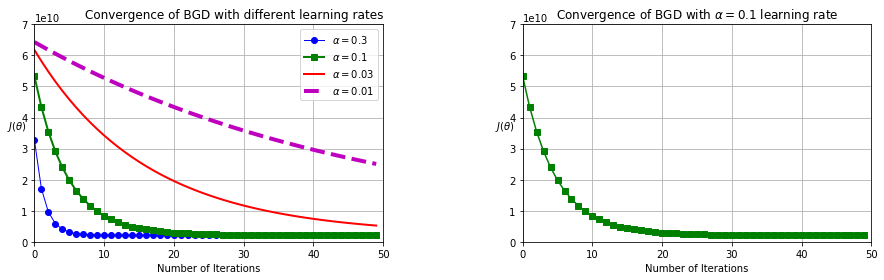

In [13]:
plt.figure(figsize=(15,4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(1, 2, 1)
learning_rates = (0.3, 0.1, 0.03, 0.01)
computeMultipleCost(X_new, Y, num_iters, learning_rates)

plt.subplot(1, 2, 2)
convergencePlot(J_history)
plt.show

You can observe from the graph on the `left` that the most appropriate $\alpha$ value is **0.1**. The same can be seen on the plot from the right side.

In [14]:
#NORMALIZING TEST X
test_x = [[1650, 3]] # 1650 sq-ft & 3 br house
norm_x = np.divide((test_x - mu),sigma) # Subtracting the mean and scaling by the standard deviation
test_x = np.insert(norm_x,0,1,axis=1) # Adding an extra column of ones to the example
print('\nNormalized Test X [[1650, 3]]: ' + str(test_x) + '\n') # RESULTS CHECK
price = hypothesisFunction(test_x,theta); #Calling the prediction function
print('Predicted price of a 1650 sq-ft, 3 br house (using gradient descent): $%.2f' % (price));


Normalized Test X [[1650, 3]]: [[ 1.         -0.44604386 -0.22609337]]

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent): $292679.07


## Part 2: Normal Equations

In order to find the value of $\theta$ that minimizes the objective function, there exist a `closed-form solution`. This is a mathematical equation that gives the results directly called `The "Normal Equation"`. The normal equation computes the optimum theta without iteration and there is no need to do feature scaling when applied.

$$\theta = {(X^T X)^{-1}.X^T.y} \tag{7}$$

Now we can implement the `Normal equation` using the `pinv()` from the NumPy Linear Algebra module (`np.linal`) to compute the inverse of a matrix and a `dot()` method for matrix multiplication.

In [15]:
def normalEqn(x, y):
    #NORMALEQN Computes the closed-form solution to linear regression 
    #NORMALEQN(X,y) computes the closed-form solution to linear regression using the normal equations.
    theta = np.zeros((x.shape[1], 1))
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(x.T,x)), x.T),y)
    return theta

In [16]:
X = np.insert(X,0,1,axis=1) # Add intercept term to X (unnormalized)
# RESULTS CHECK
print('\nThe first 5 Normalized Features are:\n', X[0:5,:])


The first 5 Normalized Features are:
 [[   1 2104    3]
 [   1 1600    3]
 [   1 2400    3]
 [   1 1416    2]
 [   1 3000    4]]


In [17]:
# Computing theta using Normal Equation
theta = normalEqn(X, Y)
# Display Normal Equaltion's result
print('\nTheta computed from Normal Equations: ' + str(theta[:,0]) + '\n');


Theta computed from Normal Equations: [89597.90954355   139.21067402 -8738.01911255]



In [18]:
# Estimate the price of a 1650 sq-ft, 3 br house
# Recall that the first column of X is all-ones. Thus, it does not need to be normalized.

input_x = [[1, 1650, 3]]
price = hypothesisFunction(input_x,theta); #Calling the prediction function
print('\nPredicted price of a 1650 sq-ft, 3 br house (using Normal Equations): $%.2f' % (price));


Predicted price of a 1650 sq-ft, 3 br house (using Normal Equations): $293081.46


## Summary

The computed thetas are somewhat different. Though, both techniques are making approximately same value for test example (x).